In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from tqdm import tqdm

In [2]:
FILENAMES = os.listdir(os.path.join('Data', 'UTKFace'))
FILENAMES[:5]

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg']

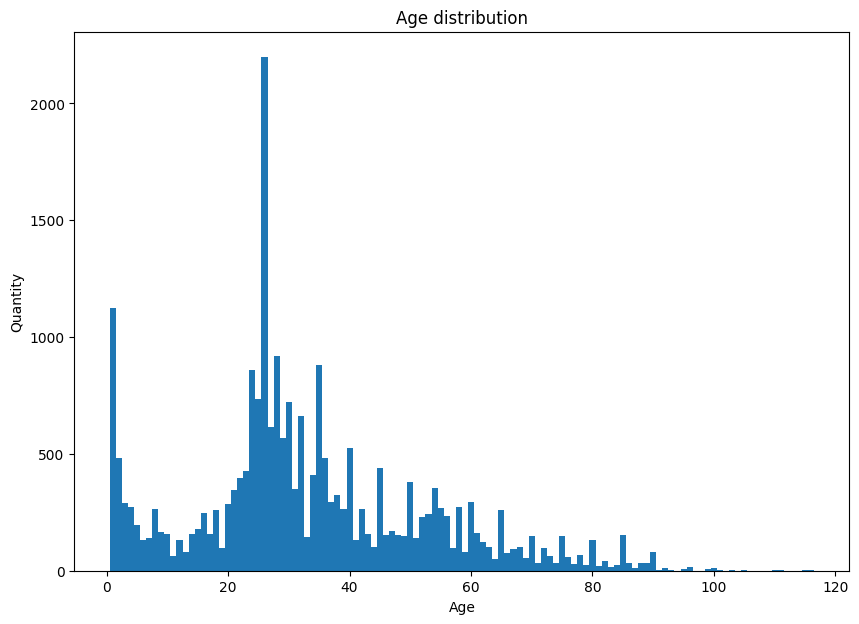

In [3]:
ages = [int(x.split('_')[0]) for x in FILENAMES]
age_distribution = {}
for i in range(min(ages), max(ages)+1):
    age_distribution[i] = 0
    
for age in ages:
    age_distribution[age] += 1

plt.figure(figsize=(10, 7))
plt.bar(age_distribution.keys(), age_distribution.values(), width=1)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Quantity')
plt.show()

['1 - 15', '16 - 30', '31 - 45', '46 - 60', '61 - 116']


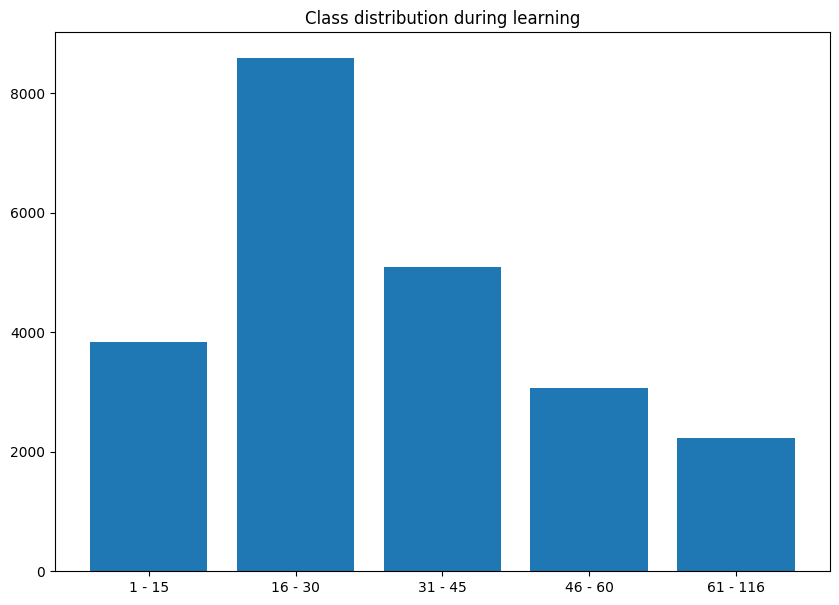

In [4]:
# AGE_THRESHOLDS = [2, 7, 14, 20, 25, 29, 35, 40, 48, 55, 65]
# AGE_THRESHOLDS = [10, 20, 30, 45, 60]
AGE_THRESHOLDS = [15, 30, 45, 60]
AGE_THRESHOLDS.insert(0, min(ages)-1)
AGE_THRESHOLDS.append(max(ages))

CLASS_NAMES = []

age_classes_distribution = {}
for i_thresh, thresh in enumerate(AGE_THRESHOLDS[:-1]):
    class_name = f'{thresh+1} - {AGE_THRESHOLDS[i_thresh + 1]}'
    CLASS_NAMES.append(class_name)
#     classes_middle.append((thresh + 1 + AGE_THRESHOLDS[i_thresh + 1])/2)
    age_classes_distribution[class_name] = 0
    
print(CLASS_NAMES)
    
i = 0

for age in age_distribution:
    if age <= AGE_THRESHOLDS[i+1]:
        age_classes_distribution[CLASS_NAMES[i]] += age_distribution[age]
    else:
        i += 1
        
plt.figure(figsize=(10, 7))
plt.bar(age_classes_distribution.keys(), age_classes_distribution.values())
plt.title('Class distribution during learning');

Text(0.5, 1.0, 'Class weights during learning')

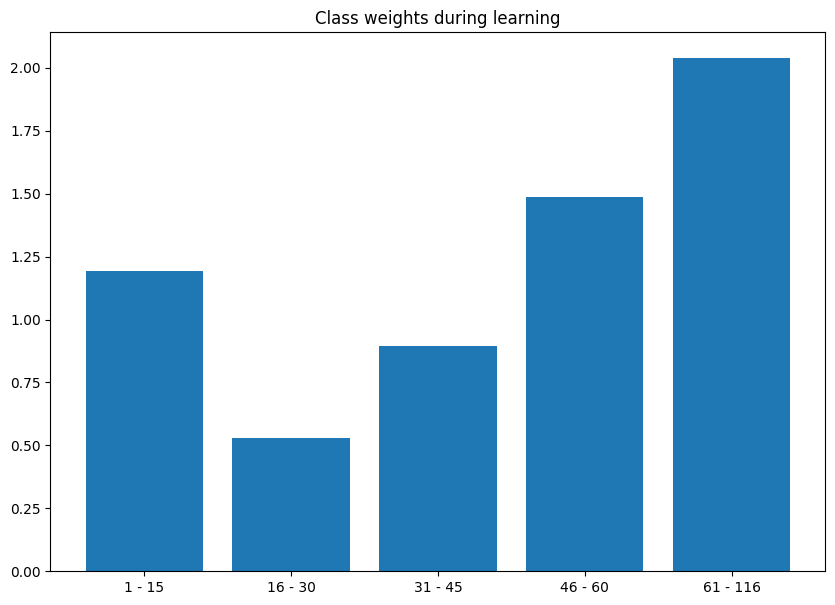

In [5]:
y = [key for key in age_classes_distribution.keys() for _ in range(age_classes_distribution[key])]
CLASS_WEIGHTS = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=CLASS_NAMES, y=y)

plt.figure(figsize=(10, 7))
plt.bar(CLASS_NAMES, CLASS_WEIGHTS)
plt.title('Class weights during learning')

# LEARNING

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
import sklearn

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()

cuda:0


In [8]:
class AgeImageDataset(Dataset):
    def __init__(self, images_dir):
        self.images_dir = images_dir
        self.images_names = os.listdir(self.images_dir)
    
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image = read_image(os.path.join(self.images_dir, image_name)) / 255.
        label_temp = image_name.split('_')[0]
        for i in range(len(AGE_THRESHOLDS) - 1):
            if AGE_THRESHOLDS[i] < int(label_temp) <= AGE_THRESHOLDS[i+1]:
                label = i
                break
        return image.float(), label

In [9]:
train_dataset = AgeImageDataset(os.path.join('Data', 'Train'))
test_dataset = AgeImageDataset(os.path.join('Data', 'Test'))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

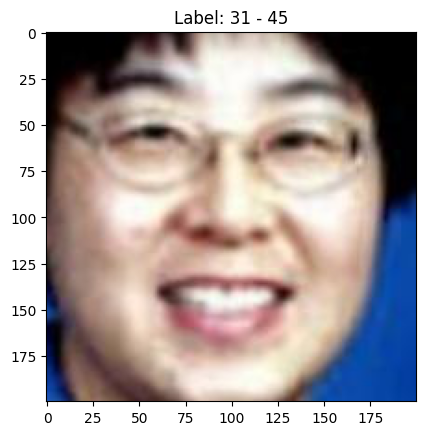

In [10]:
def show_random_photo():
    data = next(iter(train_dataloader))
    photo = data[0][0]
    label = data[1][0]
    plt.imshow(np.transpose(photo, (1, 2, 0)))
    plt.title(f'Label: {CLASS_NAMES[label]}')
#     print(label)

show_random_photo()

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Conv2d(3, 8, 5)
        self.l2 = nn.Conv2d(8, 64, 5)
        self.l3 = nn.Conv2d(64, 128, 5)
        self.l4 = nn.Conv2d(128, 256, 5)
        self.l5 = nn.Conv2d(256, 256, 5)
        self.l6 = nn.Linear(1024, 128)
        self.l7 = nn.Linear(128, len(CLASS_NAMES))
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l5(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.l6(x))
        x = self.l7(x)
                
        return x.double()


In [12]:
model = Model()
model.to(device)
print(model(torch.randn(1, 3, 200, 200).to(device)).shape)

torch.Size([1, 5])


In [13]:
def calculate_accuracy(pred, y):
    pred = np.array(pred.cpu().detach().numpy())
    y = np.array(y.cpu())
    predicted_classes = [np.argmax(x) for x in pred]
    return sum(predicted_classes == y)/len(y)

In [14]:
EPOCHS = 3

In [15]:
model.to(device)

loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(CLASS_WEIGHTS).to(device))
# loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

train_losses = []
test_losses = []

train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    train_losses_epoch = []
    test_losses_epoch = []
    
    train_acc_epoch = []
    test_acc_epoch = []
    
    # Train
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(X)
        pred = pred.to(torch.float32)
        
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
                
        train_losses_epoch.append(loss.item())
        acc = calculate_accuracy(pred, y)
        train_acc_epoch.append(acc)
        
    # Test
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        pred = pred.to(torch.float32)
        loss = loss_fn(pred, y)
        test_losses_epoch.append(loss.item())
        
        acc = calculate_accuracy(pred, y)
        test_acc_epoch.append(acc)
        
    train_losses.append(sum(train_losses_epoch)/len(train_losses_epoch))
    test_losses.append(sum(test_losses_epoch)/len(test_losses_epoch))
    train_acc.append(sum(train_acc_epoch)/len(train_acc_epoch))
    test_acc.append(sum(test_acc_epoch)/len(test_acc_epoch))
    
    print(f'Epoch {epoch+1} completed')
    print(f'Train loss: {train_losses[-1]}')
    print(f'Test loss: {test_losses[-1]}')
    print(f'Train accuracy: {train_acc[-1]}')
    print(f'Test accuracy: {test_acc[-1]}')
    print()

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:06<00:00, 22.02it/s]


Epoch 1 completed
Train loss: 1.343514923000014
Test loss: 1.1833058495649555
Train accuracy: 0.41838312053320487
Test accuracy: 0.5208233461169702



100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:06<00:00, 22.04it/s]


Epoch 2 completed
Train loss: 1.045076682535432
Test loss: 0.9723305702209473
Train accuracy: 0.546700594234321
Test accuracy: 0.5493468360498561



100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:06<00:00, 21.88it/s]

Epoch 3 completed
Train loss: 0.9354069524430505
Test loss: 0.9234623196941094
Train accuracy: 0.5868866939693247
Test accuracy: 0.558874640460211



Text(0.5, 0.98, 'Learning history')

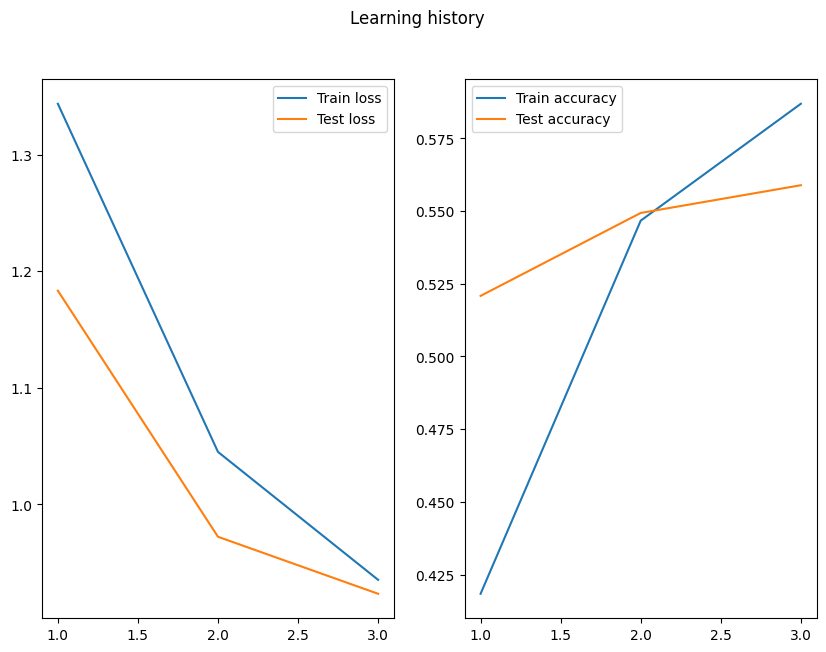

In [16]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train loss')
plt.plot(range(1, EPOCHS+1), test_losses, label='Test loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_acc, label='Train accuracy')
plt.plot(range(1, EPOCHS+1), test_acc, label='Test accuracy')
plt.legend()
plt.suptitle('Learning history')

C:\Users\Maciej\AppData\Local\Temp\ipykernel_2988\2566190983.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  photo = torch.Tensor([photo.numpy()]).to(device)


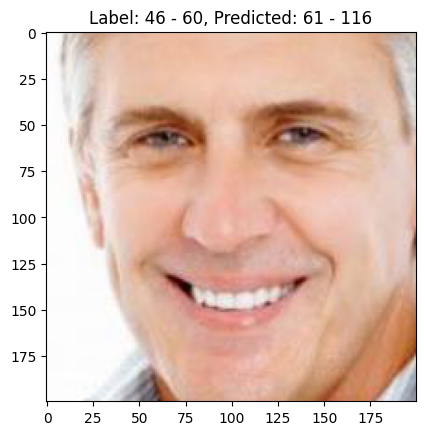

In [17]:
def predict_random_photo():
    data = next(iter(test_dataloader))
    photo = data[0][0]
    label = data[1][0]
    plt.imshow(np.transpose(photo, (1, 2, 0)))
    photo = torch.Tensor([photo.numpy()]).to(device)
    pred = torch.argmax(model(photo)[0])
    plt.title(f'Label: {CLASS_NAMES[label]}, Predicted: {CLASS_NAMES[pred]}')
#     print(label)

predict_random_photo()

# SAVING MODEL

In [18]:
from datetime import datetime

In [19]:
now = datetime.now()
MODEL_PATH = os.path.join('Models', f'Model-{now.year}.{now.month}.{now.day} {now.hour};{now.minute}') 
MODEL_PATH

'Models\\Model-2023.9.15 21;15'

In [20]:
torch.save(model.state_dict(), MODEL_PATH)

In [21]:
model = Model()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# PLAYGROUND

In [11]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.l1 = nn.Conv2d(3, 8, 5)
        self.l2 = nn.Conv2d(8, 64, 5)
        self.l3 = nn.Conv2d(64, 128, 5)
        self.l4 = nn.Conv2d(128, 256, 5)
        self.l5 = nn.Conv2d(256, 256, 5)
        self.l6 = nn.Linear(1024, 128)
        self.l7 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.l5(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.l6(x))
        x = self.l7(x)

        return x.double()


In [12]:
class AgeImageDataset(Dataset):
    def __init__(self, images_dir):
        self.images_dir = images_dir
        self.images_names = os.listdir(self.images_dir)

    def __len__(self):
        # return len(self.images_names)//10
        return len(self.images_names)

    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image = read_image(os.path.join(self.images_dir, image_name)) / 255.
        label_temp = image_name.split('_')[0]
        for i in range(len(AGE_THRESHOLDS) - 1):
            if AGE_THRESHOLDS[i] < int(label_temp) <= AGE_THRESHOLDS[i + 1]:
                label = i
                break
        return image.float(), label

In [17]:
def calculate_accuracy(pred, y):
    pred = np.array(pred.cpu().detach().numpy())
    y = np.array(y.cpu())
    predicted_classes = [np.argmax(x) for x in pred]
    return sum(predicted_classes == y)/len(y)

In [18]:
BATCH_SIZE = 32
EPOCHS = 3

train_dataset = AgeImageDataset(os.path.join('Data', 'Train'))
test_dataset = AgeImageDataset(os.path.join('Data', 'Test'))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
def train_model(model, train_dataloader, test_dataloader, device, class_weights):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))
    print('class weights', class_weights)
    # loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []

    train_acc = []
    test_acc = []

    for epoch in range(EPOCHS):
        train_losses_epoch = []
        test_losses_epoch = []

        train_acc_epoch = []
        test_acc_epoch = []

        # Train
        for X, y in tqdm(train_dataloader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            pred = model(X)
            pred = pred.to(torch.float32)

            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            train_losses_epoch.append(loss.item())
            acc = calculate_accuracy(pred, y)
            train_acc_epoch.append(acc)

        # Test
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.to(torch.float32)
            loss = loss_fn(pred, y)
            test_losses_epoch.append(loss.item())

            acc = calculate_accuracy(pred, y)
            test_acc_epoch.append(acc)

        train_losses.append(sum(train_losses_epoch) / len(train_losses_epoch))
        test_losses.append(sum(test_losses_epoch) / len(test_losses_epoch))
        train_acc.append(sum(train_acc_epoch) / len(train_acc_epoch))
        test_acc.append(sum(test_acc_epoch) / len(test_acc_epoch))

        print(f'Epoch {epoch + 1} completed')
        print(f'Train loss: {train_losses[-1]}')
        print(f'Test loss: {test_losses[-1]}')
        print(f'Train accuracy: {train_acc[-1]}')
        print(f'Test accuracy: {test_acc[-1]}')
        print()
#         mlflow.log_metric("train_losses", train_losses[-1])
#         mlflow.log_metric("test_losses", test_losses[-1])
#         mlflow.log_metric("train_acc", train_acc[-1])
#         mlflow.log_metric("test_acc", test_acc[-1])

    return model, train_losses, test_losses, train_acc, test_acc
model = Model(len(AGE_THRESHOLDS) - 1)

train_model(model, train_dataloader, test_dataloader, device, CLASS_WEIGHTS)

class weights [1.19106583 0.53102725 0.89681353 1.48854065 2.03908766]


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:10<00:00, 13.62it/s]


Epoch 1 completed
Train loss: 1.5644753395405426
Test loss: 1.2718829436590207
Train accuracy: 0.2925098369870714
Test accuracy: 0.475611217641419



100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:10<00:00, 13.88it/s]


Epoch 2 completed
Train loss: 1.150637993322054
Test loss: 1.0246604597008468
Train accuracy: 0.5094028547337991
Test accuracy: 0.552372962607862



100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:09<00:00, 15.19it/s]

Epoch 3 completed
Train loss: 0.9676682373122462
Test loss: 0.9547587349110802
Train accuracy: 0.5799907652774432
Test accuracy: 0.5945290028763184



(Model(
   (l1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
   (l2): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1))
   (l3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
   (l4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
   (l5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
   (l6): Linear(in_features=1024, out_features=128, bias=True)
   (l7): Linear(in_features=128, out_features=5, bias=True)
 ),
 [1.5644753395405426, 1.150637993322054, 0.9676682373122462],
 [1.2718829436590207, 1.0246604597008468, 0.9547587349110802],
 [0.2925098369870714, 0.5094028547337991, 0.5799907652774432],
 [0.475611217641419, 0.552372962607862, 0.5945290028763184])